# This is the most basic example from pymc3's "Get started with PyMC3" page

Assume you have a variable mu that is distributed as a normal distrbution,
Y ~ N(mu, var) where "~" means is distributed as, mu is the expected value, 
and var is the variance error of the instrument (std or sigma is the standard 
deviation). 

Then assume that mu is a linear function of dependent parameters: alpha, 
beta1, and beta2, and independent parameters X1 and X2, i.e. 
                   mu = alpha + beta1*X1 + beta2*X2

For this model, assume a weakly informed (uninformed) prior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import optimize
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate the "true" data

In [2]:
# Intialize random number generator so we get the same set of values after every iteration.
np.random.seed(123) 

In [3]:
# The true dependent parameter values:
alpha = 1; sigma =1; beta = [1, 2.5]

In [4]:
n = 100 # Number of data points

X1 = np.random.randn(n) # Numpy's random normal distribution.
X2 = np.random.randn(n) * 0.2 # scale param

In [5]:
# Simulate observations
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(n)*sigma

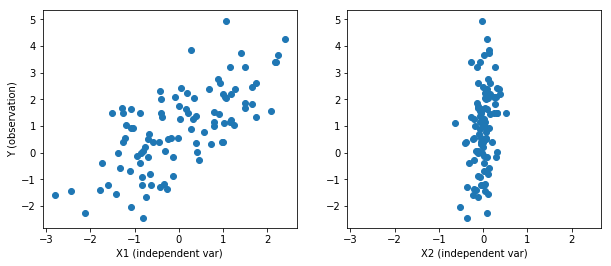

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y (observation)'); axes[0].set_xlabel('X1 (independent var)'); axes[1].set_xlabel('X2 (independent var)');

## Build the model

In [7]:
basic_model = pm.Model()

with basic_model: # This is a context manager (all command inside the width statement will be added to pm.Model(), and stay with it)
    # Prior distributions of unknowns for mu. These are STOCASTIC variables.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta  = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Define the expected value of outcome (the functional shape of what we will observe, DO NOT confuse this with the 
    # normal distribution that is assosiated with the uncertainty!). 
    # This value is DETERMANISTIC (depends on the parent values that can be stocastic)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    # Observed stocastic, the data likeleyhood, with the observed values of Y must be untouched.
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y) # 

## Fit the model

### Using the maxium a posteriori (MAP) method. Quick and dirty

In [8]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1329.64it/s] 


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

### Using the automated chooser (No-U-Turn Sampler (NUTS))

In [9]:
with basic_model:
    trace = pm.sample(500) # Draw 500 posterior samples suing NUTS

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:00<00:00, 1108.09it/s]


### Why did it do 1000 draws?

In [10]:
trace['beta']

array([[0.80231762, 2.39908581],
       [0.87814728, 2.67735218],
       [0.93472133, 2.62604647],
       ...,
       [0.76676449, 2.86037903],
       [1.03939188, 2.37197113],
       [1.11952204, 2.45856324]])

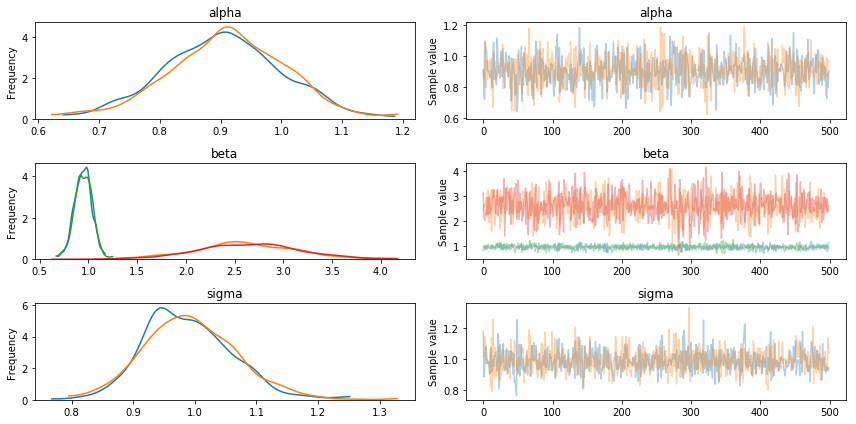

In [11]:
_ = pm.traceplot(trace)

In [12]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.906675,0.096629,0.002495,0.720351,1.099434,1362.727785,1.000215
beta__0,0.945807,0.089158,0.002246,0.766764,1.114167,1549.998899,0.999802
beta__1,2.617628,0.520785,0.012797,1.611075,3.668492,1412.044997,1.000894
sigma,0.990047,0.073049,0.001817,0.840327,1.123786,1296.002998,1.000244
